## Analysing a network of Wikipedia references

### Introduction

### Getting Data and Building the Network 

#### Choosing the Seed

In [1]:
## Seed choosed is "Data engineering" - https://en.wikipedia.org/wiki/Data_engineering
SEED = "Data engineering"
STOPS = ("International Standard Serial Number",
        "International Standard Book Number",
        "National Diet Library",
        "International Standard Name Identifier",
        "International Standard Book Number (Identifier)",
        "Pubmed Identifier",
        "Pubmed Central",
        "Digital Object Identifier",
        "Arxiv",
        "Proc Natl Acad Sci Usa",
        "Bibcode",
        "Library Of Congress Control Number",
        "Jstor",
        "Doi (Identifier)",
        "Isbn (Identifier)",
        "Pmid (Identifier)",
        "Arxiv (Identifier)",
        "Bibcode (Identifier)",
        'S2Cid (Identifier)',
        'Issn (Identifier)',
        'Oclc (Identifier)',
        'Open Library (Identifier)',
        )

#### Building Implementation

In [2]:
!pip install networkx
!pip install wikipedia

In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
#wikipedia.set_lang("pt")

In [3]:
todo_1st = [(0, SEED)] # List of the next links to be searched. (0, SEED) means that the link SEED is at distance 0 from the SEED.
todo_set = set(SEED) # Set of the next links to be searched. 
done_set = set() # Set of the links already searched.

In [4]:
g = nx.DiGraph()
layer, page = todo_1st[0]

In [5]:
%time
while layer < 2:
    # Remove the name page of the current page from the todo_1st,
    # and add it to the set of processed pages.
    # If the script encounters this page again, it will skip over it.
    del todo_1st[0]
    done_set.add(page)

    #Show progress
    print(layer, page)

    # Attempt to download the selected page.
    try:
        wiki = wikipedia.page(page, auto_suggest=False)
    except:
        layer, page = todo_1st[0]
        print("Could not load", page)
        continue

    for link in wiki.links:
        link = link.title()
        if not link.startswith("List Of") and link not in STOPS:
            if link not in todo_set and link not in done_set:
                todo_1st.append((layer + 1, link))
                todo_set.add(link)
            g.add_edge(page, link)
    layer, page = todo_1st[0]

Wall time: 0 ns
0 Data engineering
1 Acid
1 Abstract Model
Could not load Agile Software Development
1 Agile Software Development
1 Airbnb
1 Algorithms
1 Amazon (Company)
Could not load Apache Airflow
1 Apache Airflow
1 Apache Spark
1 Apple Inc.
1 Artificial Intelligence
1 Big Data
1 Binary Data
Could not load Block Storage
1 Block Storage
Could not load Business Analyst
1 Business Analyst
1 Business Intelligence
1 Clive Finkelstein
1 Cloud Computing
1 Computer
1 Computer Data Storage
Could not load Computer File
1 Computer File
Could not load Computer Science
1 Computer Science
1 Cybersecurity
1 Data
1 Data Analytics
1 Data Cleaning
1 Data Infrastructure
1 Data Lake
Could not load Data Mining
1 Data Mining
1 Data Model
1 Data Modelling
1 Data Processing
1 Data Protection
1 Data Science
1 Data Warehouse
1 Database Administrator
1 Database Design
1 Databases
1 Dataflow Programming
Could not load Deep Learning
1 Deep Learning
1 Differential Dataflow
Could not load Directed Acyclic Graph


In [6]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))


18380 nodes, 29346 edges


#### Cleaning the Network

##### Removing Duplicates

In [7]:
# make a copy of raw graph
original = g.copy()

In [8]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Computer', 'Computers'), ('Internet', 'Internets'), ('Relational Database', 'Relational Databases'), ('Amino Acid', 'Amino Acids'), ('Aqueous Solution', 'Aqueous Solutions'), ('Digestive Enzyme', 'Digestive Enzymes'), ('Lewis Acid', 'Lewis Acids'), ('Organic Acid', 'Organic Acids'), ('Medical Device', 'Medical Devices'), ('Algorithm Characterization', 'Algorithm Characterizations'), ('Calculation', 'Calculations'), ('Differential Equation', 'Differential Equations'), ("Euclid'S Element", "Euclid'S Elements"), ('Genetic Algorithm', 'Genetic Algorithms'), ('Heuristic', 'Heuristics'), ('Mathematician', 'Mathematicians'), ('Programming Language', 'Programming Languages'), ('Random Variable', 'Random Variables'), ('Randomized Algorithm', 'Randomized Algorithms'), ('Roman Numeral', 'Roman Numerals'), ('Turing Machine', 'Turing Machines'), ('Computer Cluster', 'Computer Clusters'), ('Computer Network', 'Computer Networks'), ('Data Center', 'Data Centers'), ('Database', 'Databases'), ('Deci

In [9]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

18241 nodes, 29252 edges


##### Truncate the network

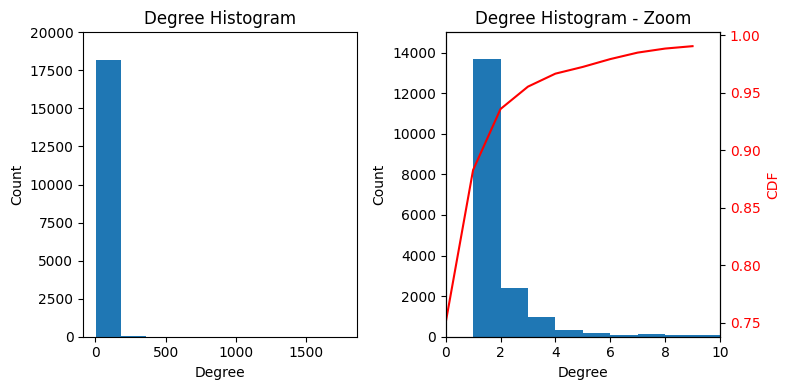

In [16]:
import numpy as np

plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,20000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

# Add function CDF to the plot using a secondary axis
ax2 = ax[1].twinx()
ax2.plot(np.cumsum(np.array([len([d for d in degree_sequence if d == i]) for i in range(1,11)]))/len(degree_sequence), color="red")
ax2.set_ylabel("CDF", color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.tight_layout()
plt.show()

In [17]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "cna.graphml")

4564 nodes, 15575 edges


In [18]:
print("Nodes removed: {:.2f}%".format(100*(1 - len(gsub.nodes)/len(g.nodes))))
print("Edges removed: {:.2f}%".format(100*(1 - len(gsub.edges)/len(g.edges))))
print("Final Edges per nodes ration: {:.2f}".format(len(gsub.edges)/len(gsub.nodes)))

Nodes removed: 74.98%
Edges removed: 46.76%
Final Edges per nodes ration: 3.41


In [19]:
import pandas as pd
graphs_mdata_df = pd.DataFrame( columns=['Original', 'Cleaned'], index=['Nodes', 'Edges', 'Edges per Nodes'] )
graphs_mdata_df['Original'] = [ len(g.nodes), len(g.edges), len(g.edges)/len(g.nodes) ]
graphs_mdata_df['Cleaned'] = [ len(gsub.nodes), len(gsub.edges), len(gsub.edges)/len(gsub.nodes) ]
graphs_mdata_df.round(2)

,Original,Cleaned
Nodes,18241.0,4564.00
Edges,29252.0,15575.00
Edges per Nodes,1.6,3.41


### Data Analysis

#### Cumulative Density Function (CDF)

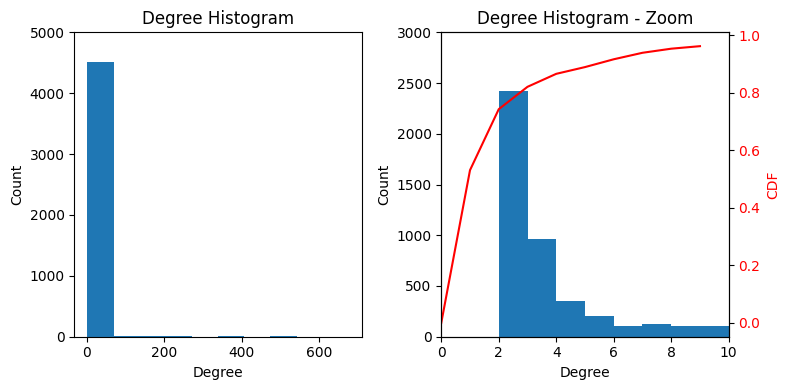

In [24]:
import numpy as np

plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,5000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,3000)

# Add function CDF to the plot using a secondary axis
ax2 = ax[1].twinx()
ax2.plot(np.cumsum(np.array([len([d for d in degree_sequence if d == i]) for i in range(1,11)]))/len(degree_sequence), color="red")
ax2.set_ylabel("CDF", color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.tight_layout()
plt.show()

#### Probability Density Function (PDF)

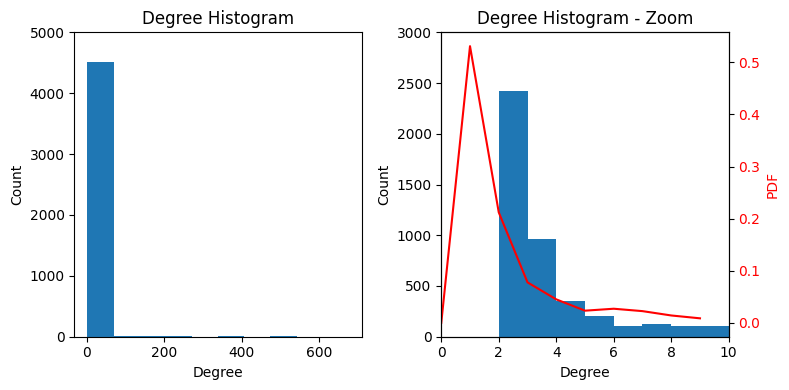

In [26]:
import numpy as np

plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,5000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,3000)

# Add function PDF to the plot using a secondary axis
ax2 = ax[1].twinx()
ax2.plot(np.array([len([d for d in degree_sequence if d == i]) for i in range(1,11)])/len(degree_sequence), color="red")
ax2.set_ylabel("PDF", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.tight_layout()
plt.show()

#### Degree Centrality

Top 10 nodes by degree centrality:
('Apple Inc.', 0.148)
('Artificial Intelligence', 0.139)
('Google', 0.137)
('Machine Learning', 0.132)
('Database', 0.124)
('Microsoft', 0.117)
('Statistic', 0.117)
('Internet', 0.109)
('Data-Mining', 0.109)
('Data', 0.101)


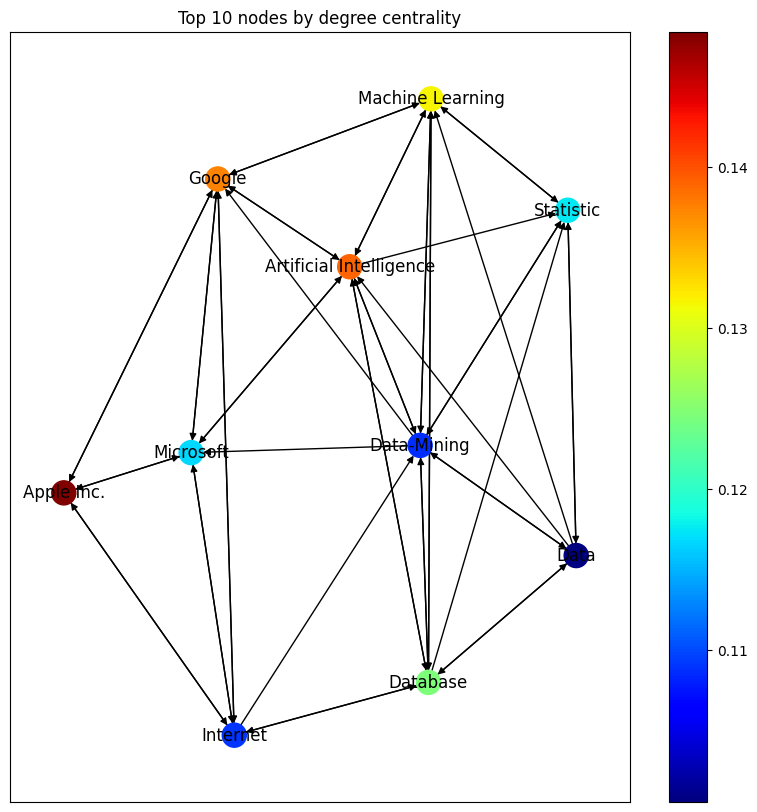

In [27]:
# Plot the degree centrality
## Calculate centrality values for all nodes in the subgraph
deg_cen = nx.degree_centrality(gsub)

## Create a list of centralities for each node
node_and_deg_cent = [(node, round(deg_cen[node], 3)) for node in deg_cen]

## Sort the list in descending order
sorted_node_and_deg_cent = sorted(node_and_deg_cent, key=itemgetter(1), reverse=True)

## Getting the top 10 nodes by degree centrality
top_10 = sorted_node_and_deg_cent[:10]

## Print the top 10 nodes and their degree centralities
print("Top 10 nodes by degree centrality:")
for node in top_10:
    print(node)

## Create a subgraph of gsub consisting only of the top 10 nodes
top_10_nodes = [node[0] for node in top_10]
gsub_degree = gsub.subgraph(top_10_nodes)

## Draw the subgraph
plt.figure(figsize=(10, 10))
plt.title("Top 10 nodes by degree centrality")

### Color the nodes in the subgraph in scale of their degree centrality
node_color = [deg_cen[node] for node in gsub_degree]
nx.draw_networkx(gsub_degree, pos=nx.kamada_kawai_layout(gsub_degree, scale=2), node_color=node_color, with_labels=True, cmap=plt.cm.jet)

### Add a color bar beside the graph
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm._A = []
plt.colorbar(sm)

plt.show()



#### Closeness Centality

Top 10 nodes by closeness centrality:
('Computer Science', 0.009)
('Database', 0.009)
('Wayback Machine', 0.009)
('Internet', 0.008)
('Big Data', 0.008)
('Ibm', 0.008)
('Data Compression', 0.008)
('Computer Hardware', 0.008)
('Software Quality', 0.008)
('Computer Programming', 0.008)


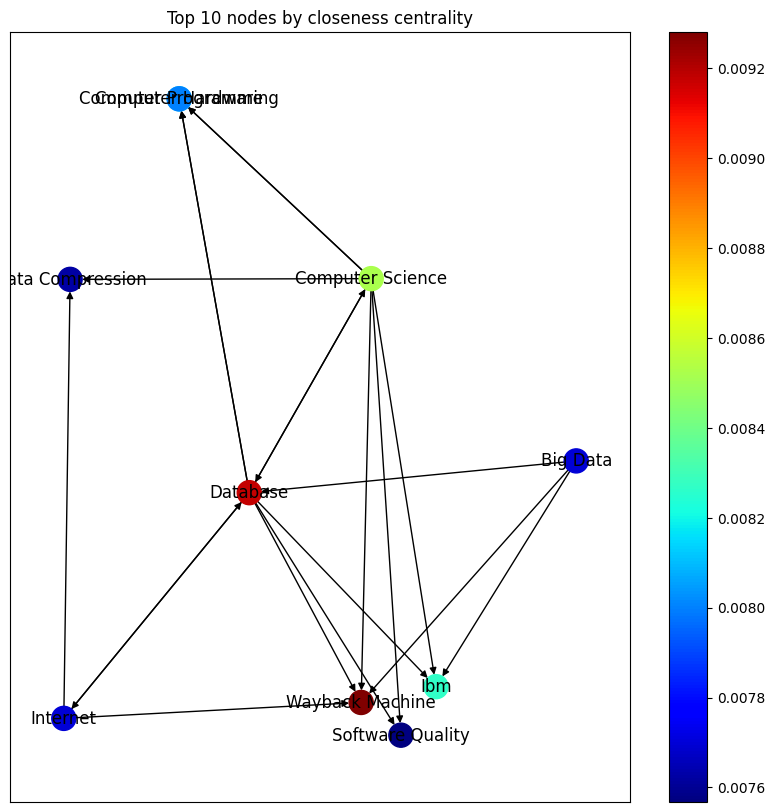

In [28]:
# Plot the closeness centrality
## Calculate centrality values for all nodes in the subgraph
clo_cen = nx.closeness_centrality(gsub)

## Create a list of centralities for each node
node_and_clo_cent = [(node, round(clo_cen[node], 3)) for node in clo_cen]

## Sort the list in descending order
sorted_node_and_clo_cent = sorted(node_and_clo_cent, key=itemgetter(1), reverse=True)

## Getting the top 10 nodes by closeness centrality
top_10 = sorted_node_and_clo_cent[:10]

## Print the top 10 nodes and their degree centralities
print("Top 10 nodes by closeness centrality:")
for node in top_10:
    print(node)

## Create a subgraph of gsub consisting only of the top 10 nodes
top_10_nodes = [node[0] for node in top_10]
gsub_closeness = gsub.subgraph(top_10_nodes)

## Draw the subgraph
plt.figure(figsize=(10, 10))
plt.title("Top 10 nodes by closeness centrality")

### Color the nodes in the subgraph in scale of their degree centrality
node_color = [clo_cen[node] for node in gsub_closeness]
nx.draw_networkx(gsub_closeness, pos=nx.kamada_kawai_layout(gsub_closeness, scale=2), node_color=node_color, with_labels=True, cmap=plt.cm.jet)

### Add a color bar beside the graph
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm._A = []
plt.colorbar(sm)

plt.show()


#### Betweenness Centrality

Top 10 nodes by betweenness centrality:
('Microsoft', 0.002)
('Database', 0.002)
('Internet', 0.001)
('Facebook', 0.001)
('Big Data', 0.001)
('Data', 0.001)
('Google', 0.001)
('Software', 0.001)
('Apple Inc.', 0.001)
('Information Technology', 0.001)


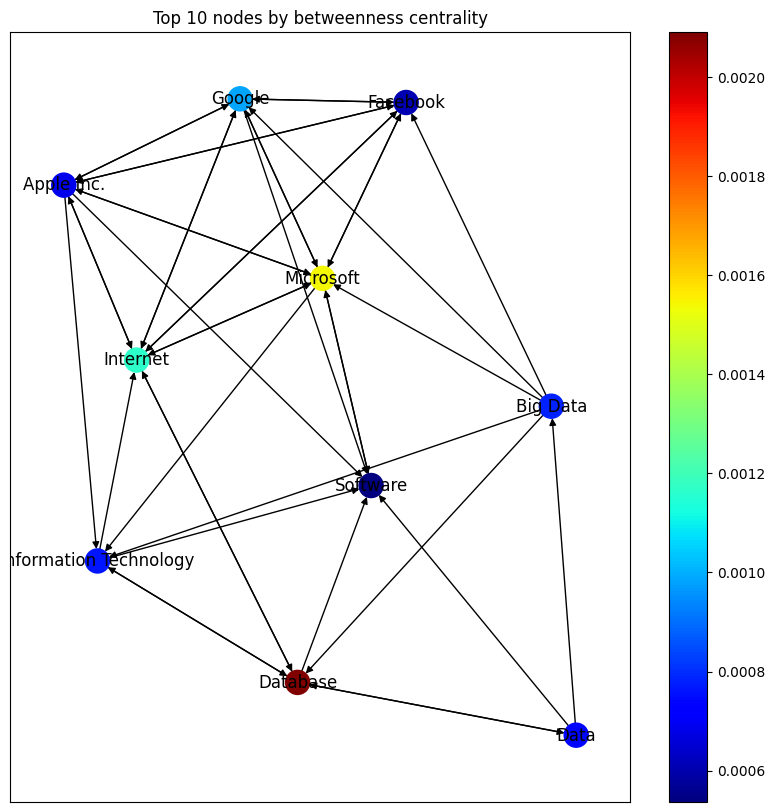

In [29]:
# Plot the beetweenness centrality
## Calculate centrality values for all nodes in the subgraph
bet_cen = nx.betweenness_centrality(gsub)

## Create a list of centralities for each node
node_and_bet_cent = [(node, round(bet_cen[node], 3)) for node in bet_cen]

## Sort the list in descending order
sorted_node_and_bet_cent = sorted(node_and_bet_cent, key=itemgetter(1), reverse=True)

## Getting the top 10 nodes by betweenness centrality
top_10 = sorted_node_and_bet_cent[:10]

## Print the top 10 nodes and their degree centralities
print("Top 10 nodes by betweenness centrality:")
for node in top_10:
    print(node)

## Create a subgraph of gsub consisting only of the top 10 nodes
top_10_nodes = [node[0] for node in top_10]
gsub_betweenness = gsub.subgraph(top_10_nodes)

## Draw the subgraph
plt.figure(figsize=(10, 10))
plt.title("Top 10 nodes by betweenness centrality")

### Color the nodes in the subgraph in scale of their degree centrality
node_color = [bet_cen[node] for node in gsub_betweenness]

nx.draw_networkx(gsub_betweenness, pos=nx.kamada_kawai_layout(gsub_betweenness, scale=2), node_color=node_color, with_labels=True, cmap=plt.cm.jet)

### Add a color bar beside the graph
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm._A = []
plt.colorbar(sm)

plt.show()

#### Eigenvector Centrality

Top 10 nodes by eigenvector centrality:
('Database', 0.094)
('Wayback Machine', 0.09)
('Data-Mining', 0.087)
('Computer Science', 0.075)
('Algorithm', 0.072)
('Machine Learning', 0.071)
('Computer Network', 0.065)
('Ibm', 0.064)
('Computer Hardware', 0.064)
('Artificial Intelligence', 0.064)


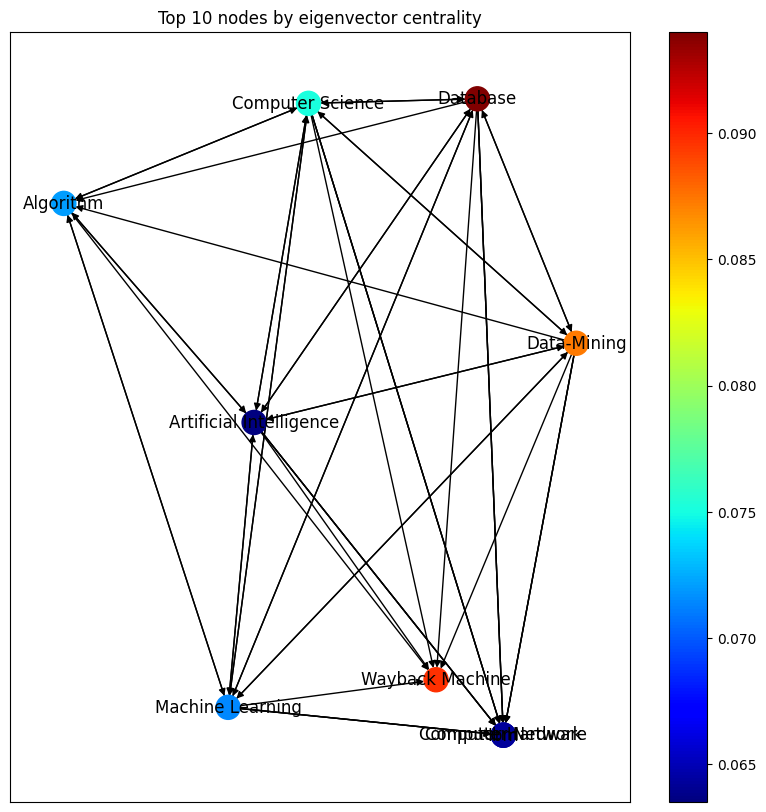

In [31]:
# Plot the eigenvector centrality
## Calculate centrality values for all nodes in the subgraph
eig_cent = nx.eigenvector_centrality(gsub)

## Create a list of centralities for each node
node_and_eig_cent = [(node, round(eig_cent[node], 3)) for node in eig_cent]

## Sort the list in descending order
sorted_node_and_eig_cent = sorted(node_and_eig_cent, key=itemgetter(1), reverse=True)

## Getting the top 10 nodes by eigenvector centrality
top_10 = sorted_node_and_eig_cent[:10]

## Print the top 10 nodes and their degree centralities
print("Top 10 nodes by eigenvector centrality:")
for node in top_10:
    print(node)

## Create a subgraph of gsub consisting only of the top 10 nodes
top_10_nodes = [node[0] for node in top_10]
gsub_eigenvector = gsub.subgraph(top_10_nodes)

## Draw the subgraph
plt.figure(figsize=(10, 10))
plt.title("Top 10 nodes by eigenvector centrality")

### Color the nodes in the subgraph in scale of their degree centrality
node_color = [eig_cent[node] for node in gsub_eigenvector]
nx.draw_networkx(gsub_eigenvector, pos=nx.kamada_kawai_layout(gsub_eigenvector, scale=2), node_color=node_color, with_labels=True, cmap=plt.cm.jet)

### Add a color bar beside the graph
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm._A = []
plt.colorbar(sm)

plt.show()

#### Merging Plots

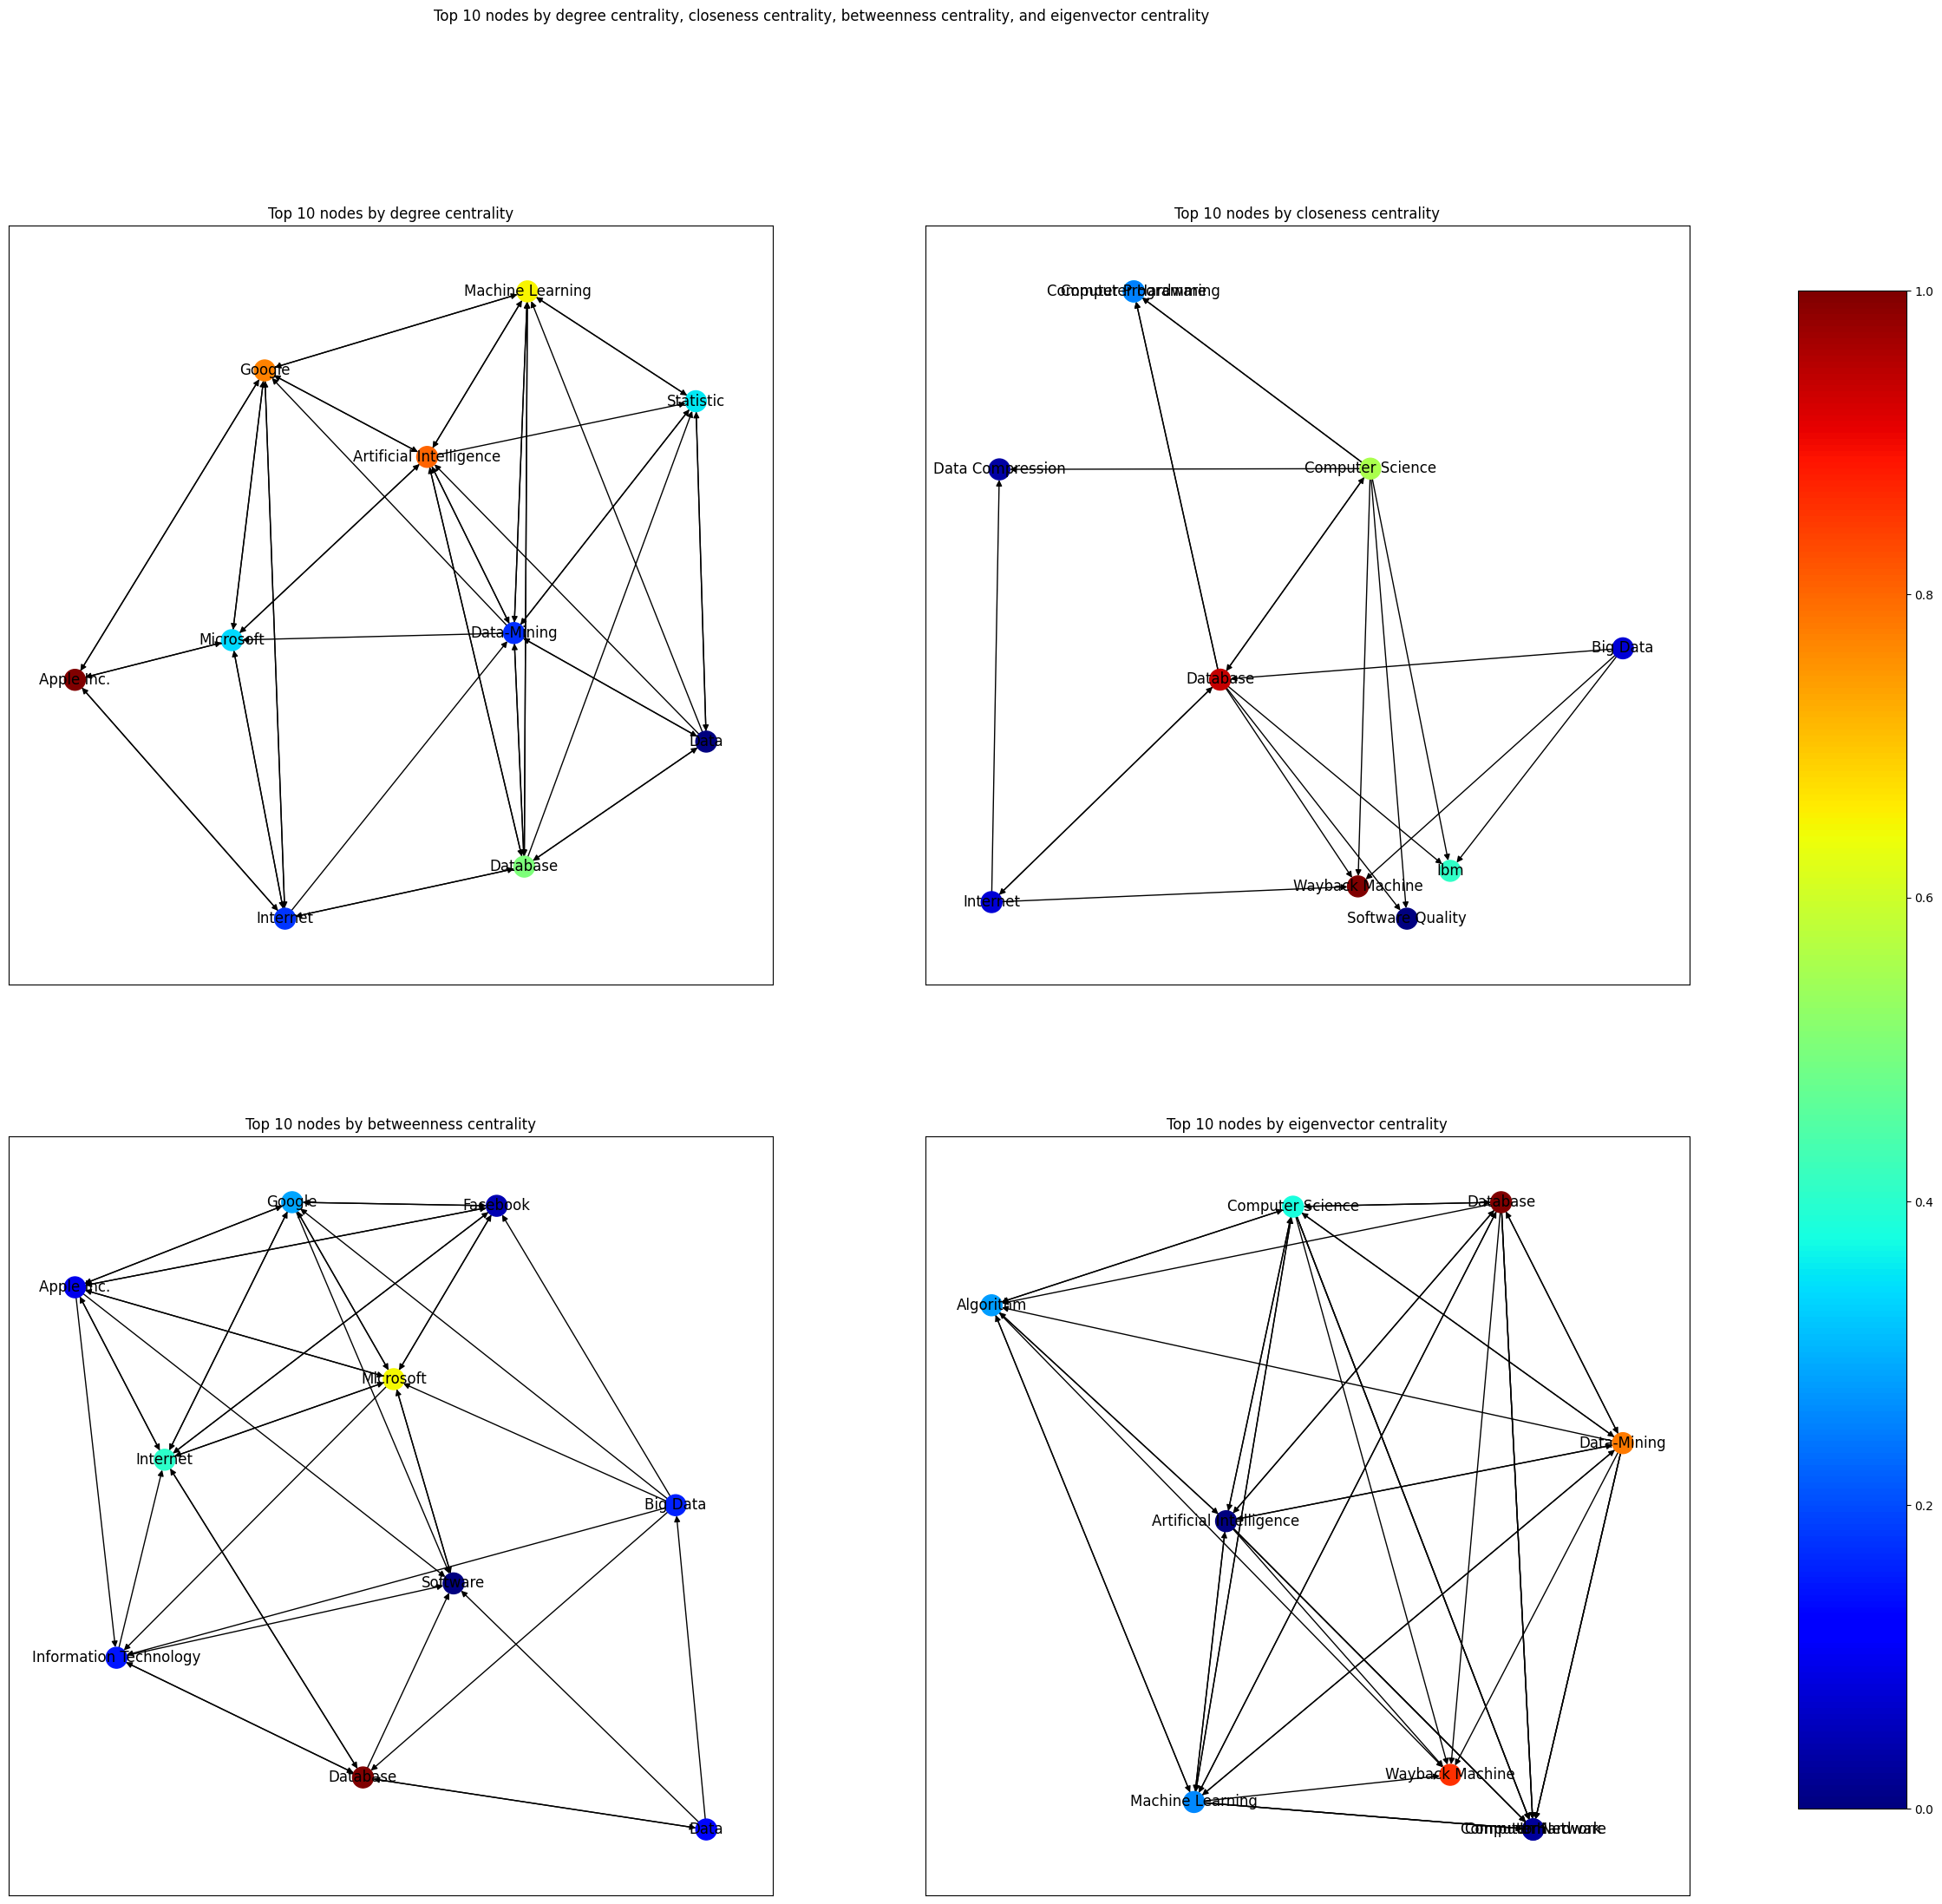

In [32]:
# Plot the degree centrality, closeness centrality, betweenness centrality, and eigenvector centrality in one single graph with four subplots

## Calculate centrality values for all nodes in the subgraph
deg_cen = nx.degree_centrality(gsub)
clo_cen = nx.closeness_centrality(gsub)
bet_cen = nx.betweenness_centrality(gsub)
eig_cen = nx.eigenvector_centrality(gsub)

## Create a list of centralities for each node
node_and_deg_cent = [(node, round(deg_cen[node], 3)) for node in deg_cen]
node_and_clo_cent = [(node, round(clo_cen[node], 3)) for node in clo_cen]
node_and_bet_cent = [(node, round(bet_cen[node], 3)) for node in bet_cen]
node_and_eig_cent = [(node, round(eig_cen[node], 3)) for node in eig_cen]

## Sort the list in descending order
sorted_node_and_deg_cent = sorted(node_and_deg_cent, key=itemgetter(1), reverse=True)
sorted_node_and_clo_cent = sorted(node_and_clo_cent, key=itemgetter(1), reverse=True)
sorted_node_and_bet_cent = sorted(node_and_bet_cent, key=itemgetter(1), reverse=True)
sorted_node_and_eig_cent = sorted(node_and_eig_cent, key=itemgetter(1), reverse=True)

## Getting the top 10 nodes by degree centrality
top_10_deg = sorted_node_and_deg_cent[:10]
top_10_clo = sorted_node_and_clo_cent[:10]
top_10_bet = sorted_node_and_bet_cent[:10]
top_10_eig = sorted_node_and_eig_cent[:10]

## Create a subgraph of gsub consisting only of the top 10 nodes
top_10_nodes_deg = [node[0] for node in top_10_deg]
top_10_nodes_clo = [node[0] for node in top_10_clo]
top_10_nodes_bet = [node[0] for node in top_10_bet]
top_10_nodes_eig = [node[0] for node in top_10_eig]

gsub_deg = gsub.subgraph(top_10_nodes_deg)
gsub_clo = gsub.subgraph(top_10_nodes_clo)
gsub_bet = gsub.subgraph(top_10_nodes_bet)
gsub_eig = gsub.subgraph(top_10_nodes_eig)

## Draw the subgraph
plt.figure(figsize=(25, 25))
plt.suptitle("Top 10 nodes by degree centrality, closeness centrality, betweenness centrality, and eigenvector centrality")

### Color the nodes in the subgraph in scale of their degree centrality
plt.subplot(2, 2, 1)
plt.title("Top 10 nodes by degree centrality")
node_color_deg = [deg_cen[node] for node in gsub_deg]
nx.draw_networkx(gsub_deg, pos=nx.kamada_kawai_layout(gsub_deg, scale=2), node_color=node_color_deg, with_labels=True, cmap=plt.cm.jet)

### Color the nodes in the subgraph in scale of their closeness centrality
plt.subplot(2, 2, 2)
plt.title("Top 10 nodes by closeness centrality")
node_color_clo = [clo_cen[node] for node in gsub_clo]
nx.draw_networkx(gsub_clo, pos=nx.kamada_kawai_layout(gsub_clo, scale=2), node_color=node_color_clo, with_labels=True, cmap=plt.cm.jet)


### Color the nodes in the subgraph in scale of their betweenness centrality
plt.subplot(2, 2, 3)
plt.title("Top 10 nodes by betweenness centrality")
node_color_bet = [bet_cen[node] for node in gsub_bet]
nx.draw_networkx(gsub_bet, pos=nx.kamada_kawai_layout(gsub_bet, scale=2), node_color=node_color_bet, with_labels=True, cmap=plt.cm.jet)


## Color the nodes in the subgraph in scale of their eigenvector centrality
plt.subplot(2, 2, 4)
plt.title("Top 10 nodes by eigenvector centrality")
node_color_eig = [eig_cen[node] for node in gsub_eig]
nx.draw_networkx(gsub_eig, pos=nx.kamada_kawai_layout(gsub_eig, scale=2), node_color=node_color_eig, with_labels=True, cmap=plt.cm.jet)

### Add a color bar in the top right corner of the graph
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar_ax = plt.axes([0.95, 0.15, 0.05, 0.7])
plt.colorbar(sm, cax=cbar_ax)


#### Comparison

In [21]:
import seaborn as sns
# check seaborn version
print(sns.__version__)

0.10.1


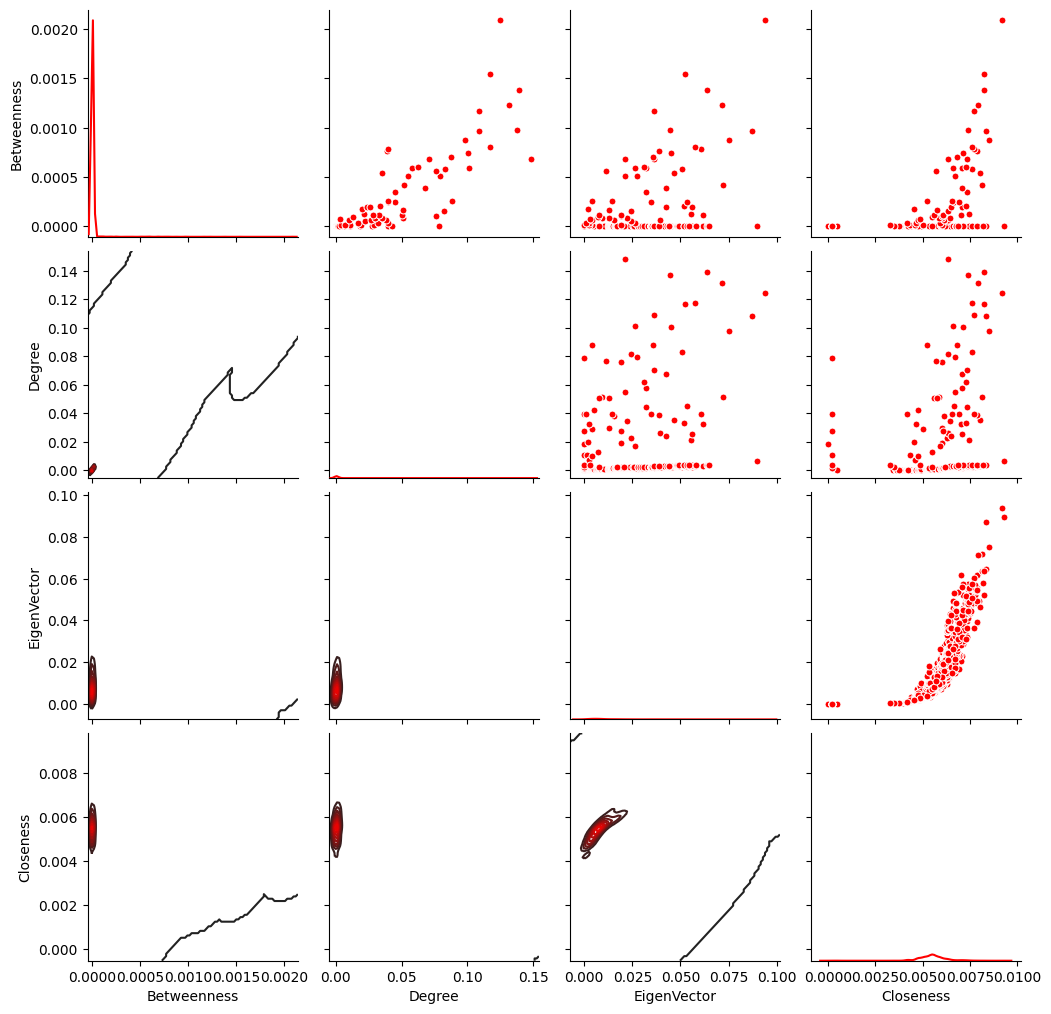

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

def plot_all_centrality(g):
    df = pd.DataFrame.from_dict({
        "Betweenness": pd.Series(nx.betweenness_centrality(g)),
        "Degree": pd.Series(nx.degree_centrality(g)),
        "EigenVector": pd.Series(nx.eigenvector_centrality(g)),
        "Closeness": pd.Series(nx.closeness_centrality(g))
    })
    df = df.sort_values(by=list(df.columns))
    df.reset_index(inplace=True, drop=True)
    fig = sns.PairGrid(df)
    fig.map_upper(sns.scatterplot, color="red", s=25)
    fig.map_lower(sns.kdeplot, color="red")
    fig.map_diag(sns.kdeplot, legend=False, color="red")
    plt.show()

plot_all_centrality(gsub)

#### Core and Shell

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
['Software Architecture', 'Computer Program', 'Twitter', 'Database Transaction', 'Data Mesh', 'Application Programming Interface', 'Image Compression', 'Lars Rönnnbäck', 'Networking Hardware', 'System On A Chip', 'Xml For Analysis', 'Statistical Inference', 'Computational Social Science', 'Iso/Iec 15504', 'Dimension (Data Warehouse)', 'Systems Development Life Cycle', 'Bill Inmon', 'C Sharp (Programming Language)', 'Business Insider', 'Anchor Modeling', 'Dimension Table', 'Youtube', 'Rendering (Computer Graphics)', 'Intel', 'Comparison Of Olap Servers', 'Sixth Normal Form', 'Bbc News', 'Ralph Kimball', 'Interaction Design', 'Acid', 'Amazon Web Services', 'Wired (Magazine)', 'Project Management', 'Systems Modeling Language', 'Association For Computing Machinery', 'Service-Oriented Architecture', 'Document-Oriented Database', 'Systems Analyst', 'Holap', 'Automated Planning And Scheduling', 'Function Model', 'Business Intelligence Software'

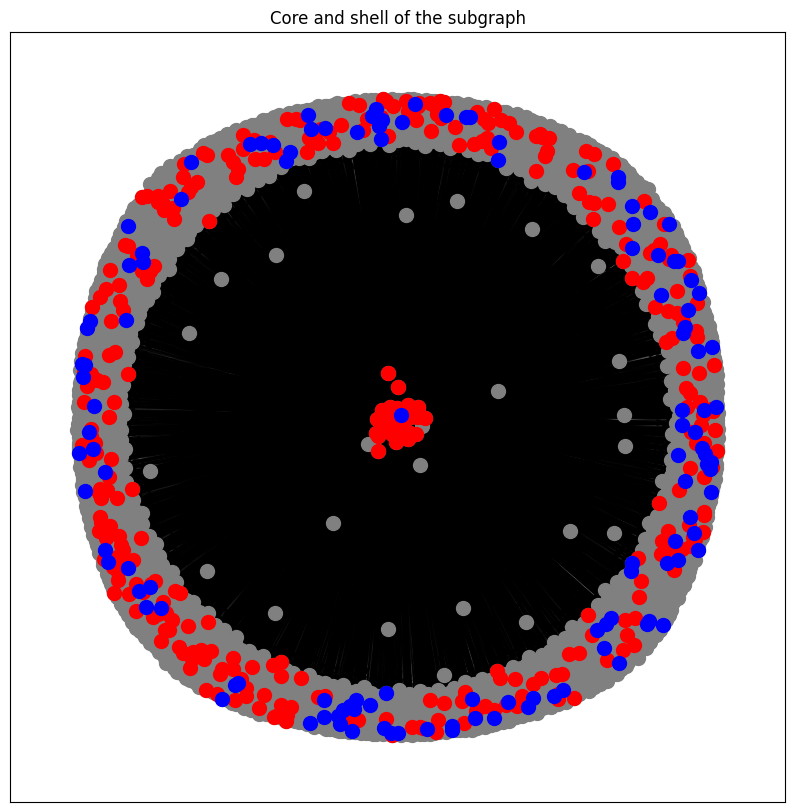

In [34]:
# How many k-cores does this network have?
print(set([v for k, v in nx.core_number(gsub).items()]))

# Who are in the innermost core?
print(list(nx.k_shell(gsub, k=8)))

# Plot core and shell
core = nx.k_core(gsub, k=8)
shell = nx.k_shell(gsub, k=7)

print("Core nodes: ", core.nodes())
print("Shell nodes: ", shell.nodes())

plt.figure(figsize=(10, 10))
plt.title("Core and shell of the subgraph")

pos = nx.spring_layout(gsub, seed=707)

nx.draw_networkx_edges(gsub, pos, alpha=0.4)

nx.draw_networkx_nodes(gsub, pos, node_size=100, node_color="grey")
nx.draw_networkx_nodes(core, pos, node_size=100, node_color="red")
nx.draw_networkx_nodes(shell, pos, node_size=100, node_color="blue")


plt.show()



### Gephi

![Alt text]( "a title")